In [368]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import os
from uncertainties import ufloat
from scipy.optimize import curve_fit

In [238]:
sizes = pd.read_csv('/Users/js/school/phy224/fluid/sizes.csv')
sizes['radius'] = sizes.diameter / 2

In [665]:
session = '2' #either '1' or '2'
fluid = 'glycerine' #either 'water' or 'glycerine'

maindir = f'/Users/js/school/phy224/fluid/drops{session}/{fluid}'

In [666]:
def get_colours(palette, n):
    clrs = []
    cmap = matplotlib.cm.get_cmap(palette, n)
    for i in range(cmap.N):
        rgb = cmap(i)[:3]
        clrs.append(matplotlib.colors.rgb2hex(rgb))
    return clrs

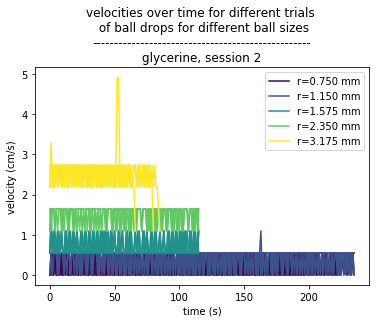

In [667]:
n = len(os.listdir(maindir))
cols = get_colours('viridis', n)
allmeans = [0] * n # mean velocities for each ball size
for size in sorted(os.listdir(maindir)):
    meanvels = [] # mean velocity over all trial drops for a ball of a given size
    for dropnum in os.listdir(f'{maindir}/{size}'): # loop over each trial
        if dropnum.endswith('.txt'):
            time, pos = np.loadtxt(f'{maindir}/{size}/{dropnum}', unpack=True, skiprows=2)
            time = np.array([ufloat(i, 0.0005) for i in time.tolist()])
            pos = np.array([ufloat(j, 0.002) for j in pos.tolist()])
            condition = pos > 1e-6
            time, pos = time[condition], pos[condition]
            vel = np.diff(pos)
#             plt.plot([k.nominal_value for k in vel]) # include this plot, explain why chop off first couple. 
            vel = vel[3:]
            plt.plot([k.nominal_value for k in vel], c=cols[int(size)-1])
            plt.xlabel('time (s)')
            plt.ylabel('velocity (cm/s)')
            plt.title(f'velocities over time for different trials \n of ball drops for different ball sizes\n{"-"*50}\n{fluid}, session {session}')
            meanvels.append(vel.mean())
    plt.plot([],[], c=cols[int(size)-1], label=f'r={sizes[sizes.fluid == fluid].radius.values[(int(size)-1)]:.3f} mm')
    plt.legend()
    meanvels = np.array(meanvels)
    allmeans[int(size)-1] = meanvels.mean()
plt.savefig(f'{fluid}{session}.png')

In [668]:
def wallcorr(v, d, D):
    return v / (1 - 2.104*(d/D) + 2.089*(d/D)**2)

In [669]:
corrvels = [(wallcorr(v/100, d/1000, 0.095) * 100) for d, v in zip(sizes[sizes.fluid == fluid].diameter, allmeans)]
for j in corrvels:
    print(j)

0.194356+/-0.000008
0.438823+/-0.000007
0.778362+/-0.000015
1.675689+/-0.000016
2.879749+/-0.000025


In [670]:
def reynolds(rho, v, l, eta):
    return (rho * v * l) / eta

In [671]:
dens = 1.26 if fluid == 'glycerine' else 1.
visc = 9.34 if fluid == 'glycerine' else 0.01

reys = [(reynolds(dens, v, d/10, visc)) for d, v in zip(sizes[sizes.fluid == fluid].diameter, corrvels)]
for r in reys:
    print(r)

0.00393291+/-0.00000016
0.01361573+/-0.00000023
0.0330762+/-0.0000006
0.1062466+/-0.0000010
0.2466903+/-0.0000021


In [672]:
def model(x, a, b):
    return a * x**b

def model1(x, a):
    return a * x**2

def model2(x, a):
    return a * x**0.5

In [673]:
popt, pcov = curve_fit(f=model, xdata=sizes[sizes.fluid == fluid].radius, ydata=[i.nominal_value for i in corrvels], sigma=[j.std_dev for j in corrvels], absolute_sigma=True)
popt2, pcov2 = curve_fit(f=model1, xdata=sizes[sizes.fluid == fluid].radius, ydata=[i.nominal_value for i in corrvels], sigma=[j.std_dev for j in corrvels], absolute_sigma=True)
print(popt)
print(popt2)

[0.33834671 1.8589864 ]
[0.29908702]


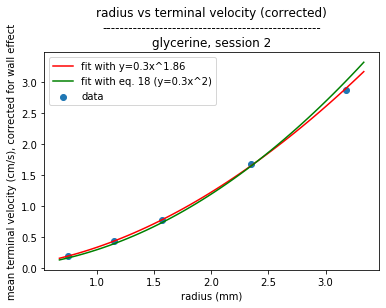

In [674]:
xdat = np.linspace(min(sizes[sizes.fluid == fluid].radius)*0.9, max(sizes[sizes.fluid == fluid].radius)*1.05)
plt.scatter(sizes[sizes.fluid == fluid].radius, [i.nominal_value for i in corrvels], label='data')
plt.plot(xdat, model(xdat, *popt), c='r', label=f'fit with y={popt[0]:.1f}x^{popt[1]:.2f}')
plt.plot(xdat, model1(xdat, *popt2), c='g', label=f'fit with eq. 18 (y={popt2[0]:.1f}x^2)')
plt.xlabel('radius (mm)')
plt.ylabel('mean terminal velocity (cm/s), corrected for wall effect')
plt.title(f'radius vs terminal velocity (corrected)\n{"-"*50}\n{fluid}, session {session}')
plt.legend();